$k$-means is a popular basic unsupervised clustering algorithm.  What most people don't realize is the connection between $k$-means and Gaussian Mixture Models (GMMs).  We can see this simply by looking at the loss functions.  

For $k$-means the loss function is defined as 
$$
\arg \min_{\mu} \sum_{i=1}^{n} \sum_{j=1}^{k} 1(x_{i} \text{ is closest to } \mu_{j}) || x_{i} - \mu_{j} ||^{2}.
$$

For Gaussian Mixture Models, the log-likehood is defined as 
$$
\sum_{i = 1}^{n} \sum_{j=1}^{k} \log p_{j} + || x_{i} - \mu_{j} ||^2 / \sigma_{j}^{2} - \log \sigma_{j} - 2 \log 2\pi.
$$
If we instead represent the GMM in the complete likelihood form, as one would in the EM formulation to estimating the parameters, we define $Z_{i} \in \{ 1, \ldots, k \}$ to be the component that $x_{i}$ arose from.  The complete likelihood is therefore,
$$
\sum_{i=1}^{n} 1(Z_{i} = k) \big( \log p_{j} + || x_{i} - \mu_{j} ||^2 / \sigma_{j}^{2} - \log \sigma_{j} - 2 \log 2\pi \big).
$$
If we set $\sigma_{j} = 1$ for all $j$ and $p_{j} = 1/k$ then the loss functions are identical up to a constant (which is of course irrelevant).    

Most people use the $k$-means, but there are significant advantages to using the GMM framework.  In particular, if we let $\sigma_{j}$ vary, then that allows the radii of the clusters to vary (implicitly, $k$-means assumes all clusters are the same radius).  Additionally, the optimization of $k$-means can get stuck in local optima, for example if all the data is positive and you initialize one component to have mean -100 and the other to have mean 1, then all the points will be assigned to the second cluster and the updates won't change it.  The GMM formulation will not get stuck because the probabilistic assignment will allow the EM algorithm to escape the initialization. 

The two also differ in their philosophy.  $k$-means is concerned with the problem of partitioning the data into optimal clusters, which is of course an NP-hard problem (discrete optimization problems usually are).  On the other hand, GMMs make assumptions about the structure of the data and then make inferences based on that assumed structure.  The assumptions could be (and commonly are) wrong, but insights gained from incorrect assumptions may still be valuable.  

Let's compare the two, building each from scratch

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

def logsumexp(x):
    c = x.max()
    return c + np.log(np.sum(np.exp(x - c)))

def expectation_step(x, params):
    k = len(params['p'])
    z = np.zeros((x.shape[0], k))
    for i in range(x.shape[0]):
        for j in range(k):
            z[i,j] = np.log(params['p'][j]) + multivariate_normal.logpdf(x[i,:], mean=params['mu'][j], cov=params['sigma'][j])
        log_const = logsumexp(z[i,:])
        for j in range(k):
            z[i,j] = np.exp(z[i,j] - log_const)
    return z

def max_step(x, z, sigma_const=True):
    k = z.shape[1]
    mu = [0]*k
    sigma = [1]*k
    p=[1.0/k]*k
    for i in range(k):
        probs=z[:,i]
        p[i]=np.mean(probs)
        mu[i]=np.mean(np.multiply(x, probs[:,np.newaxis]), axis=0)/p[i]
        if not sigma_const:
            x2=np.square(x - mu[i])
            zi=z[:,i]
            sigma[i] = np.mean(np.multiply(zi[:,np.newaxis], x2))/p[i]
    return {'mu': mu, 'sigma': sigma, 'p': p}
    

def gmm(x, k, initial_means, sigma_const=True, tol=1e-5, max_iter=100):
    error=float("inf")
    iter=0
    mu=initial_means
    sigma=[1]*k
    p = [1.0/k]*k
    params={'mu': mu, 'sigma': sigma, 'p': p}
    while error > tol and iter < max_iter:
        iter=iter+1
        z=expectation_step(x, params)
        params=max_step(x, z, sigma_const)
        error=np.sum(np.multiply(mu - params['mu'], mu - params['mu']))      
    return params

def gmm_assign_points(x, params):
    z=expectation_step(x, params)
    return np.apply_along_axis(np.argmax, 1, z)

 

In [2]:
# simulate x multvariate normal mixture

n=1000
x=np.concatenate([multivariate_normal.rvs(mean=[0,0], size=n), multivariate_normal.rvs(mean=[5,5], size=n)],
                    axis=0)
print(x.shape)

(2000, 2)


<Axes: >

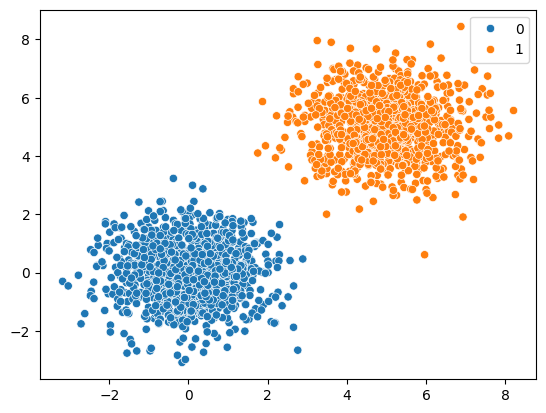

In [3]:
import seaborn
labels=[0]*n
labels.extend([1]*n)
seaborn.scatterplot(x=x[:,0], y=x[:,1], hue=labels)

In [4]:
estimated_params = gmm(x, k=2, initial_means=np.array([[0,0], [1,1]]), max_iter=100)
cluster_assignments = gmm_assign_points(x, estimated_params)

In [5]:
np.unique(cluster_assignments, return_counts=True)

(array([0, 1]), array([1000, 1000]))

In [6]:
print(estimated_params)

{'mu': [array([-0.00472313, -0.01372405]), array([4.96159947, 5.01371521])], 'sigma': [1, 1], 'p': [0.5000467417970622, 0.4999532582029379]}


In [7]:
def kmeans_assign_points(x, k, centroids):
    distances=np.zeros((x.shape[0], k))
    for i in range(k):
        #print("centroids[i,:].shape: ", centroids[i,:].shape)
        #print("x.shape: ", x.shape)
        d=np.apply_along_axis(np.sum, 1, np.square(x - centroids[i,:]))
        distances[:,i]=d
    cluster_assignments=np.apply_along_axis(np.argmin, 1, np.array(distances))
    return cluster_assignments

def kmeans_compute_centroids(x, k, cluster_assignments):
    centroids = []
    for i in range(k):
        mask = (cluster_assignments == i)
        centroid=np.mean(x[mask,:], axis=0)
        centroids.append(centroid)
    return np.array(centroids)

def lloyds_kmeans(x, k, initial_means, tol=1e-5, max_iter=100):
    error=float("inf")
    iter=0
    prev_centroids=initial_means
    centroids=initial_means
    while error > tol and iter < max_iter:
        iter=iter+1
        cluster_assignments=kmeans_assign_points(x, k, centroids)
        centroids=kmeans_compute_centroids(x, k, cluster_assignments)
        error=np.mean(np.multiply(centroids-prev_centroids, centroids-prev_centroids))
    return centroids   

In [8]:
kmeans_centroids=lloyds_kmeans(x, k=2, initial_means=np.array([[0,0], [1,1]]), max_iter=100)
cluster_assignments=kmeans_assign_points(x, k=2, centroids=kmeans_centroids)

In [9]:
np.unique(cluster_assignments, return_counts=True)

(array([0, 1]), array([1000, 1000]))

In [10]:
print(kmeans_centroids)

[[-0.00503094 -0.0139624 ]
 [ 4.96144301  5.01348358]]


In [11]:
print("distance between GMM mu's and k-means centroids: ", np.sum(np.square(kmeans_centroids -  estimated_params['mu'])))

distance between GMM mu's and k-means centroids:  2.2969197301573755e-07


In [12]:
n=500
x=np.concatenate([multivariate_normal.rvs(mean=[0,0], cov=1, size=n), multivariate_normal.rvs(mean=[2,2], cov=1, size=n), 
                 multivariate_normal.rvs(mean=[-2,-2], cov=1, size=n), multivariate_normal.rvs(mean=[-2,2], cov=1, size=n)],
                    axis=0)
print(x.shape)

(2000, 2)


<Axes: >

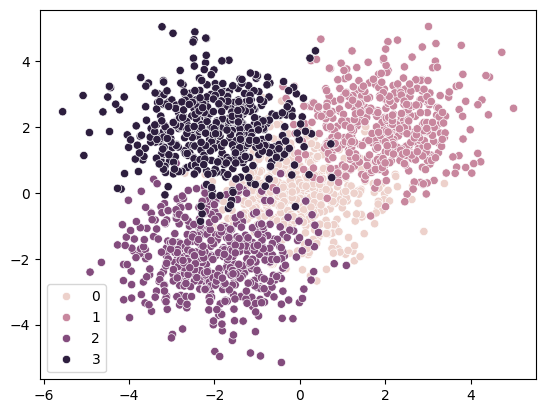

In [13]:
labels=[0]*n
labels.extend([1]*n)
labels.extend([2]*n)
labels.extend([3]*n)
seaborn.scatterplot(x=x[:,0], y=x[:,1], hue=labels)

In [14]:
estimated_params = gmm(x, k=4, initial_means=np.array([[0,0], [1,1], [-1,-1], [-1,1]]), sigma_const=False, max_iter=100)
gmm_cluster_assignments = gmm_assign_points(x, estimated_params)
np.unique(gmm_cluster_assignments, return_counts=True)

(array([0, 1, 2, 3]), array([469, 519, 503, 509]))

In [15]:
print(estimated_params)

{'mu': [array([-0.05466741, -0.00504771]), array([1.96141119, 1.9836308 ]), array([-1.9689016 , -1.96821873]), array([-1.98135399,  1.9214503 ])], 'sigma': [0.8713243224059722, 1.025224702154891, 1.0872625163254777, 1.048107131107464], 'p': [0.23328200764978788, 0.25727068593861546, 0.25140598190665586, 0.2580413245049407]}


In [16]:
kmeans_centroids=lloyds_kmeans(x, k=4, initial_means=np.array([[0,0], [1,1], [-1,-1], [-1,1]]), max_iter=100)
kmeans_cluster_assignments=kmeans_assign_points(x, k=4, centroids=kmeans_centroids)
np.unique(kmeans_cluster_assignments, return_counts=True)

(array([0, 1, 2, 3]), array([516, 504, 483, 497]))

In [17]:
print(kmeans_centroids)

[[-0.02211877 -0.0548213 ]
 [ 2.02509554  2.06039705]
 [-2.07888511 -2.05829221]
 [-2.08036559  2.0207064 ]]


In [18]:
print("distance between GMM mu's and k-means centroids: ", np.sum(np.square(kmeans_centroids -  estimated_params['mu'])))

distance between GMM mu's and k-means centroids:  0.05335025279244356


In [19]:
def clustering_accuracy(true_means, true_assignments, estimated_means, estimated_assignments):
    # because of the label swapping issue, we need to match each true mean to the corresponding closest mean
    # then compare the counts
    true_mean_2_estimated_mean = []
    for i in range(len(true_means)):
        d=[]
        for j in range(len(estimated_means)):
            d.append(np.sum(np.square(true_means[i] - estimated_means[j])))
        true_mean_2_estimated_mean.append(np.argmin(np.array(d)))
    # check if all elements are represented
    assert(len(true_mean_2_estimated_mean) == len(set(true_mean_2_estimated_mean))) 
    accuracy=0.0
    n=len(true_assignments)
    for i in range(n):
        # check if the assigned labels match
        if true_mean_2_estimated_mean[true_assignments[i]] == estimated_assignments[i]:
            accuracy=accuracy+1.0/n
    return accuracy

In [20]:
true_means = [[0,0], [2,2], [-2,-2], [-2,2]]
print("GMM accuracy: ", clustering_accuracy(true_means, labels, estimated_params['mu'], gmm_cluster_assignments))
print("k-means accuracy: ", clustering_accuracy(true_means, labels, kmeans_centroids, kmeans_cluster_assignments))

GMM accuracy:  0.8794999999999585
k-means accuracy:  0.8764999999999589


In [21]:
n=500
x=np.concatenate([multivariate_normal.rvs(mean=[0,0], cov=1, size=4*n), multivariate_normal.rvs(mean=[5,5], cov=4, size=2*n), 
                 multivariate_normal.rvs(mean=[-2.5,-2.5], cov=1, size=n), multivariate_normal.rvs(mean=[-2.5,2.5], cov=1, size=int(n/2))],
                    axis=0)
print(x.shape)

(3750, 2)


<Axes: >

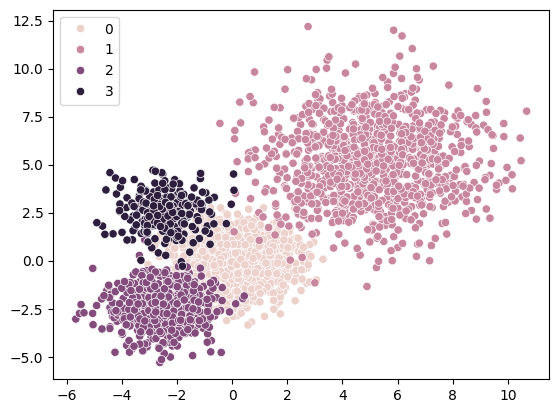

In [22]:
labels=[0]*4*n
labels.extend([1]*2*n)
labels.extend([2]*n)
labels.extend([3]*int(n/2))
seaborn.scatterplot(x=x[:,0], y=x[:,1], hue=labels)

In [23]:
estimated_params = gmm(x, k=4, initial_means=np.array([[0,0], [1,1], [-1,-1], [-1,1]]), sigma_const=False, max_iter=100)
gmm_cluster_assignments = gmm_assign_points(x, estimated_params)
np.unique(gmm_cluster_assignments, return_counts=True)

(array([0, 1, 2, 3]), array([2039,  991,  486,  234]))

In [24]:
print(estimated_params)

{'mu': [array([-0.01098998,  0.01542841]), array([4.99498615, 5.14915599]), array([-2.50910989, -2.43410884]), array([-2.5274434 ,  2.55254169])], 'sigma': [0.9713185673131987, 4.000034286600459, 1.0783519878548171, 0.7516649869031748], 'p': [0.5377266603969318, 0.26641601081829874, 0.1330356463495068, 0.06282168243526258]}


In [25]:
kmeans_centroids=lloyds_kmeans(x, k=4, initial_means=np.array([[0,0], [1,1], [-1,-1], [-1,1]]), max_iter=100)
kmeans_cluster_assignments=kmeans_assign_points(x, k=4, centroids=kmeans_centroids)
np.unique(kmeans_cluster_assignments, return_counts=True)

(array([0, 1, 2, 3]), array([1822,  946,  608,  374]))

In [26]:
print(kmeans_centroids)

[[ 0.20786794  0.03739223]
 [ 5.16922894  5.28788696]
 [-2.31802428 -2.26952533]
 [-1.97462444  2.33107659]]


In [27]:
print("distance between GMM mu's and k-means centroids: ", np.sum(np.square(kmeans_centroids -  estimated_params['mu'])))

distance between GMM mu's and k-means centroids:  0.5162450679683369


In [28]:
true_means = [[0,0], [5,5], [-2.5,-2.5], [-2.5,2.5]]
print("GMM accuracy: ", clustering_accuracy(true_means, labels, estimated_params['mu'], gmm_cluster_assignments))
print("k-means accuracy: ", clustering_accuracy(true_means, labels, kmeans_centroids, kmeans_cluster_assignments))

GMM accuracy:  0.9645333333333053
k-means accuracy:  0.9186666666666436


#### 

In [29]:
# example where k-means does better
n=1000
x1=np.c_[np.random.uniform(low=0, high=0.29, size=n), np.random.uniform(low=0, high=1, size=n)]
x2=np.c_[np.random.uniform(low=0.31, high=1, size=n), np.random.uniform(low=0, high=1, size=n)]
x = np.concatenate((x1, x2))
print(x.shape)

(2000, 2)


<Axes: >

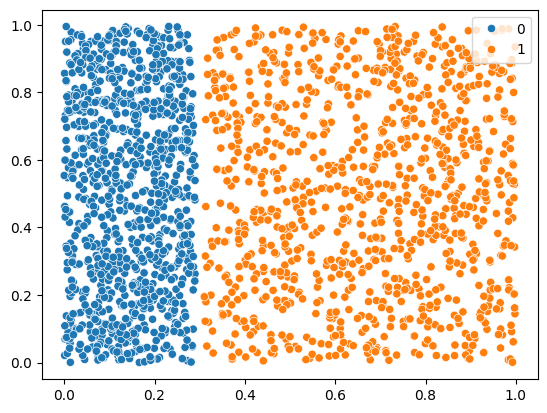

In [30]:
labels=[0]*n
labels.extend([1]*n)
seaborn.scatterplot(x=x[:,0], y=x[:,1], hue=labels)

In [31]:
estimated_params = gmm(x, k=2, initial_means=np.array([[0,0], [1,1]]), sigma_const=False, max_iter=100)
gmm_cluster_assignments = gmm_assign_points(x, estimated_params)
np.unique(gmm_cluster_assignments, return_counts=True)

(array([0, 1]), array([1278,  722]))

In [32]:
print(estimated_params)

{'mu': [array([0.24321336, 0.49251349]), array([0.63833636, 0.51240767])], 'sigma': [0.06188004397116301, 0.07868383005272865], 'p': [0.5879644570466471, 0.4120355429533529]}


In [33]:
kmeans_centroids=lloyds_kmeans(x, k=2, initial_means=np.array([[0,0], [1,1]]), max_iter=100)
kmeans_cluster_assignments=kmeans_assign_points(x, k=2, centroids=kmeans_centroids)
np.unique(kmeans_cluster_assignments, return_counts=True)

(array([0, 1]), array([1201,  799]))

In [34]:
print(kmeans_centroids)

[[0.18526135 0.49638205]
 [0.7378439  0.50721696]]


In [35]:
print("distance between GMM mu's and k-means centroids: ", np.sum(np.square(kmeans_centroids -  estimated_params['mu'])))
true_means = [[0.29/2, (1-0.31)/2], [.5,.5]]
print("GMM accuracy: ", clustering_accuracy(true_means, labels, estimated_params['mu'], gmm_cluster_assignments))
print("k-means accuracy: ", clustering_accuracy(true_means, labels, kmeans_centroids, kmeans_cluster_assignments))

distance between GMM mu's and k-means centroids:  0.013302095605601572
GMM accuracy:  0.8609999999999606
k-means accuracy:  0.8994999999999563


In this case, $k$-means performs slightly better.  Probably because the problem deviates significantly from the Gaussian assumption, so the extra optimization of different variances add unneeded variability to the solution. 

In [36]:
# taking data from the example https://kaggle.com/code/ryanholbrook/clustering-with-k-means#Example---California-Housing
data=pd.read_csv("housing.csv")
print(data.shape)
data.head(3)

(20640, 10)


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY

<Axes: xlabel='longitude', ylabel='latitude'>

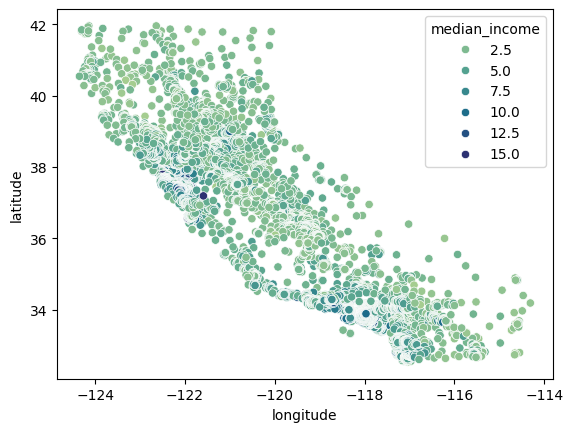

In [37]:
seaborn.scatterplot(x='longitude', y='latitude', hue='median_income', data=data, palette='crest')

In [68]:
x = data[['longitude', 'latitude', 'median_income']]
initial_means = np.array(x.sample(n=6, replace=False))
estimated_params = gmm(np.array(x), k=6, initial_means=initial_means, sigma_const=False, max_iter=100)
gmm_cluster_assignments = gmm_assign_points(np.array(x), estimated_params)

In [69]:
kmeans_centroids=lloyds_kmeans(np.array(x), k=6, initial_means=initial_means, max_iter=100)
kmeans_cluster_assignments=kmeans_assign_points(np.array(x), k=6, centroids=kmeans_centroids)

/var/folders/3s/zcxtb3wd4fl3trkdqr1zghfr0000gp/T/ipykernel_4520/2930093855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['gmm_cluster']=gmm_cluster_assignments


<Axes: xlabel='longitude', ylabel='latitude'>

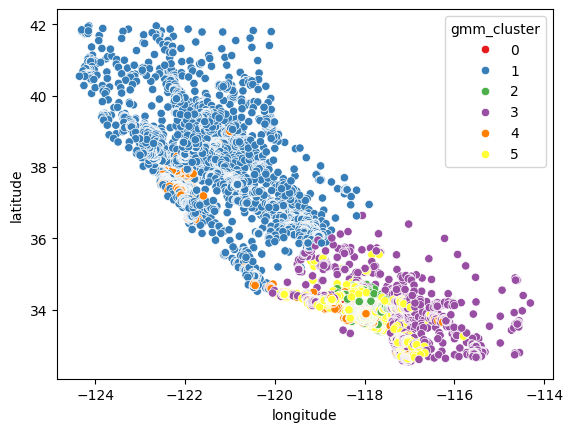

In [70]:
x['gmm_cluster']=gmm_cluster_assignments
seaborn.scatterplot(x='longitude', y='latitude', hue='gmm_cluster', data=x, palette='Set1')

/var/folders/3s/zcxtb3wd4fl3trkdqr1zghfr0000gp/T/ipykernel_4520/1790621877.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['kmeans_cluster']=kmeans_cluster_assignments


<Axes: xlabel='longitude', ylabel='latitude'>

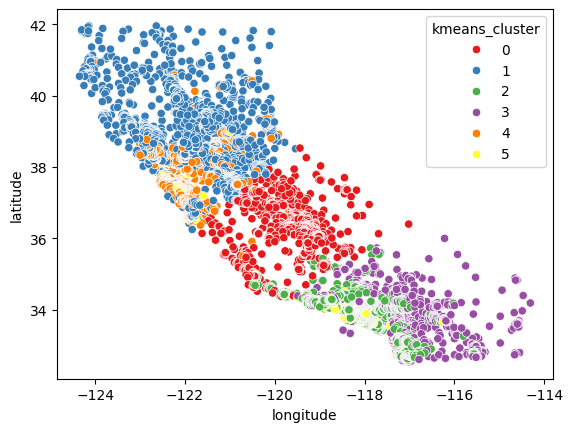

In [71]:
x['kmeans_cluster']=kmeans_cluster_assignments
seaborn.scatterplot(x='longitude', y='latitude', hue='kmeans_cluster', data=x, palette='Set1')

We see the difference between the Gaussian Mixture Model and the $k$-means model is that the GMM essentially combines clusters in Northern California, but loses clusters in Southern California.  